# 국내 외국인 근로자 산업현장 특성별 산재 유형 예측

### 배경
* **국내 체류 외국인**의 수가 날로 늘어나고 있다. 관광 목적 뿐만 아니라 유학, 결혼, 취업, 연구 등의 목적으로 체류하는 수가 많아지고 있다.
* 그 중 다수를 차지 하는 것이 **E-9 비자 비전문 취업**이다. 제조업, 건설업, 농축산업, 어업, 서비스업, 광업, 임업 분야에서 E-9 비자를 소지하고 있는 외국인근로자를 고용하고 있다.
* 외국인 고용이 가장 많은 산업은 **제조업**이다. 특히 금속 가공제품 제조업이 절대적으로 높은 비중을 차지하고 있다.
* 최근 **외국인 근로자의 노동 현장 문제** 보고가 증가했다. 특히, E-9 비자 외국인의 **산재** 및 **불법체류** 신고가 늘어나고 있다.

### 데이터

* 데이터명: **근로복지공단_외국인근로자 산재처리 상세현황_20231231**
* 제공기관: 근로복지공단
* 설명: 산재보험 최초요양신청 승인된 건들에 대한 정보 제공
    * 근로복지공단 외국인근로자 산업재해 처리현황으로 사고·질병구분, 지역본부, 사업장 규모 정도 등의 정보를 제공합니다.
* 링크: https://www.data.go.kr/data/15121557/fileData.do?recommendDataYn=Y#tab-layer-openapi

### 모델 학습 계획
* 학습 구조: 산업 업종, 산업체 지역, 사업장 규모에 따른 산업재해 발생 유형 데이터를 학습한다.
* 학습 목적: 특정 산업 업종, 산업체 지역, 사업장 규모에서 어떤 재해가 많이 발생하는지 예측할 수 있다.

### 학습 파이프라인
1. 데이터 읽기
2. EDA 및 전처리
3. 모델 구현
4. 모델 별 평가지표 비교
5. 모델 결정

### 1. 데이터 읽기

In [1]:
# 로컬에서 데이터 불러오기
from google.colab import files
uploaded = files.upload()

Saving 근로복지공단_외국인근로자 산재처리 상세현황_20231231.csv to 근로복지공단_외국인근로자 산재처리 상세현황_20231231.csv


In [12]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설치
import os
import matplotlib as mpl
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install -y fonts-nanum fonts-noto-cjk > /dev/null

candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",          # 가장 선호
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",   # 대체 1
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",   # 대체 2 (환경에 따라 위치가 다름)
]

font_path = None
for p in candidates:
    if os.path.exists(p):
        font_path = p
        break

if font_path is None:
    raise FileNotFoundError("한글 폰트를 찾지 못했습니다. 위 apt-get 설치 로그를 확인해 주세요.")

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

print(f"한글 폰트 적용: {font_name} @ {font_path}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
한글 폰트 적용: NanumGothic @ /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [13]:
# 파일 읽기
file_path = '근로복지공단_외국인근로자 산재처리 상세현황_20231231.csv'
df = pd.read_csv(file_path, encoding='cp949')

df

,연번,재해발생형태,산재업종(대분류),사업장규모,지역본부별
0,1,사고,건설업,500~1000인 미만,서울지역본부
1,2,사고,건설업,5인 미만,서울지역본부
2,3,출퇴근,제조업,5인 미만,서울지역본부
3,4,사고,기타의사업,50~100인 미만,서울지역본부
4,5,사고,기타의사업,300~500인 미만,서울지역본부
...,...,...,...,...,...
9092,9093,사고,건설업,1000인 이상,대전지역본부
9093,9094,사고,건설업,5인 미만,대전지역본부
9094,9095,사고,제조업,5인 미만,대전지역본부
9095,9096,사고,농업,5~30인 미만,대전지역본부


### 2. EDA 및 전처리

In [38]:
df.shape

(9097, 5)

In [14]:
# 컬럼별 결측치 및 dtype 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9097 entries, 0 to 9096
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연번         9097 non-null   int64 
 1   재해발생형태     9097 non-null   object
 2   산재업종(대분류)  9097 non-null   object
 3   사업장규모      9097 non-null   object
 4   지역본부별      9097 non-null   object
dtypes: int64(1), object(4)
memory usage: 355.5+ KB


In [46]:
df.drop(columns='연번', inplace=True)
df

,재해발생형태,산재업종(대분류),사업장규모,지역본부별
0,사고,건설업,500~1000인 미만,서울지역본부
1,사고,건설업,5인 미만,서울지역본부
2,출퇴근,제조업,5인 미만,서울지역본부
3,사고,기타의사업,50~100인 미만,서울지역본부
4,사고,기타의사업,300~500인 미만,서울지역본부
...,...,...,...,...
9092,사고,건설업,1000인 이상,대전지역본부
9093,사고,건설업,5인 미만,대전지역본부
9094,사고,제조업,5인 미만,대전지역본부
9095,사고,농업,5~30인 미만,대전지역본부


In [47]:
# df 결측치 확인
if (df.isnull().sum().sum() == 0) == True:
    print("결측치 없음")
else:
    print("결측치 존재")

결측치 없음


In [48]:
# 범주형 컬럼 고유값 확인
for col in df.columns:
    if df[col].dtype == 'object':
        print(col)
        print(df[col].unique())
        print(f"고유값 개수: {df[col].unique().size}")
        print()

재해발생형태
['사고' '출퇴근' '질병']
고유값 개수: 3

산재업종(대분류)
['건설업' '제조업' '기타의사업' '운수·창고및통신업' '농업' '광업' '어업' '임업' '금융및보험업']
고유값 개수: 9

사업장규모
['500~1000인 미만' '5인 미만' '50~100인 미만' '300~500인 미만' '5~30인 미만' '1000인 이상'
 '30~50인 미만' '100~300인 미만']
고유값 개수: 8

지역본부별
['서울지역본부' '강원지역본부' '부산지역본부' '대구지역본부' '경인지역본부' '광주지역본부' '대전지역본부']
고유값 개수: 7



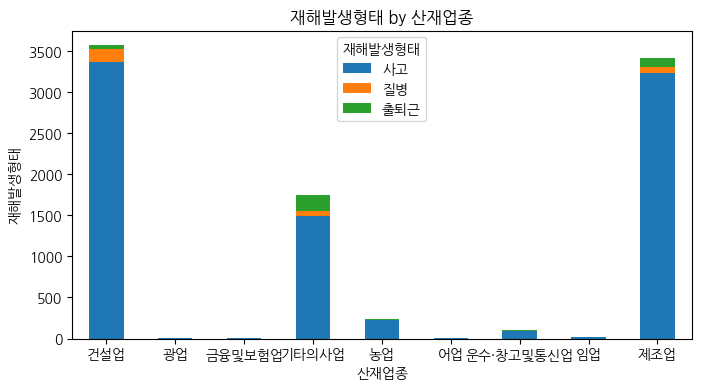

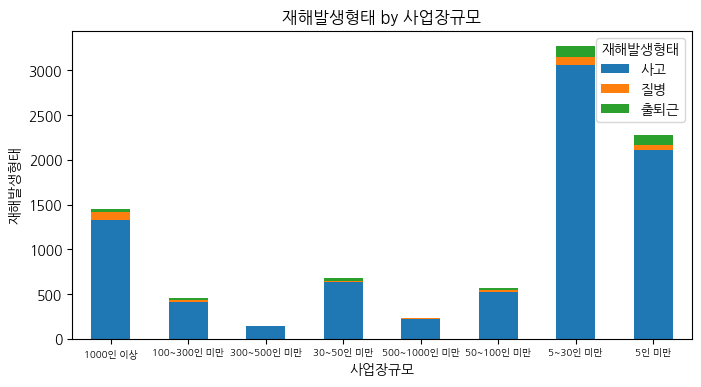

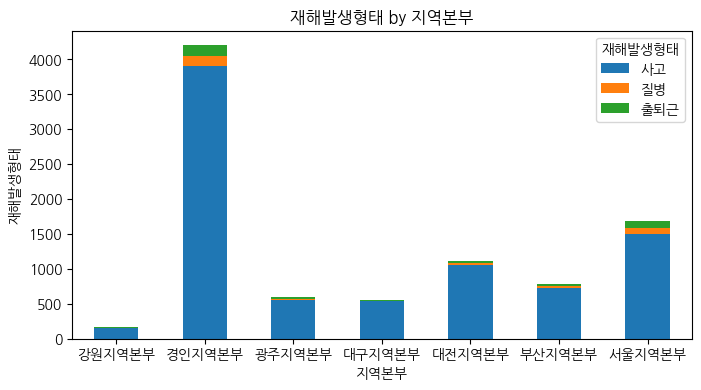

In [29]:
# 범주형 - 범주형 데이터 관계 시각화

# -- 1) 산재업종별 재해발생형태 --
contingency_table_1 = pd.crosstab(df['산재업종(대분류)'], df['재해발생형태'])
contingency_table_1.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('재해발생형태 by 산재업종')
plt.xlabel('산재업종')
plt.ylabel('재해발생형태')
plt.xticks(rotation=0)
plt.show()

# -- 2) 사업장규모별 재해발생형태 --
contingency_table_1 = pd.crosstab(df['사업장규모'], df['재해발생형태'])
contingency_table_1.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('재해발생형태 by 사업장규모')
plt.xlabel('사업장규모')
plt.ylabel('재해발생형태')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# -- 3) 지역본부별 재해발생형태 --
contingency_table_1 = pd.crosstab(df['지역본부별'], df['재해발생형태'])
contingency_table_1.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('재해발생형태 by 지역본부')
plt.xlabel('지역본부')
plt.ylabel('재해발생형태')
plt.xticks(rotation=0)
plt.show()

### 시각화 인사이트

1. 산재업종별 재해발생형태
* **건설업, 제조업** 순으로 재해발생 건수가 가장 많다.
* 재해발생형태를 보면, 사고, 질병,출퇴근 중 **사고**의 비중이 절대적으로 크다.

2. 사업장규모별 재해발생형태
* **5~30인 미만, 5인 미만, 1000인 이상** 순으로 재해발생 건수가 많다.

3. 지역본부별 재해발생형태
* **경인지역본부, 서울지역본부**순으로 재해발생 건수가 많다.


### 범주형 컬럼 인코딩
* 레이블 인코딩: 정수값으로 인코딩
* 원핫 인코딩: 0/1값만으로 인코딩, 차원의 확장 (더미 변수 생성)
* 해싱 인코딩: 해시 함수를 사용하여 범주형 값을 정수로 매핑하는 방식. 고유값 수가 수백, 수천개에 달할 때 차원 수가 폭발적으로 늘어나는 것 방지.

### 인코딩 방식 결정
* 대상 데이터의 최대 고유값 개수 = 9
* 원핫 인코딩이 가장 적합
    * 방법 1. pd.get_dummies()
    * 방법 2. sklearn.preprocessing.OneHotEncoder

In [53]:
# 컬럼 재확인
df.columns

# 컬럼명 변경
df = df.rename(columns={'산재업종(대분류)': '산재업종'})
df.columns

Index(['재해발생형태', '산재업종', '사업장규모', '지역본부별'], dtype='object')

In [59]:
# 범주형 컬럼 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder 객체 생성
encoder = OneHotEncoder(sparse_output=False)  # numpy 배열로 변환하도록 지정

# 데이터 변환
categorical_cols = ['재해발생형태', '산재업종', '사업장규모', '지역본부별']
encoded_array = encoder.fit_transform(df[categorical_cols])

# 인코딩된 NumPy 배열을 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# 원본 DataFrame의 수치형/다른 컬럼과 인코딩된 DataFrame을 병합
df_final = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

print(df_final)

      재해발생형태_사고  재해발생형태_질병  재해발생형태_출퇴근  산재업종_건설업  산재업종_광업  산재업종_금융및보험업  \
0           1.0        0.0         0.0       1.0      0.0          0.0   
1           1.0        0.0         0.0       1.0      0.0          0.0   
2           0.0        0.0         1.0       0.0      0.0          0.0   
3           1.0        0.0         0.0       0.0      0.0          0.0   
4           1.0        0.0         0.0       0.0      0.0          0.0   
...         ...        ...         ...       ...      ...          ...   
9092        1.0        0.0         0.0       1.0      0.0          0.0   
9093        1.0        0.0         0.0       1.0      0.0          0.0   
9094        1.0        0.0         0.0       0.0      0.0          0.0   
9095        1.0        0.0         0.0       0.0      0.0          0.0   
9096        1.0        0.0         0.0       1.0      0.0          0.0   

      산재업종_기타의사업  산재업종_농업  산재업종_어업  산재업종_운수·창고및통신업  ...  사업장규모_50~100인 미만  \
0            0.0      0.0      0.0

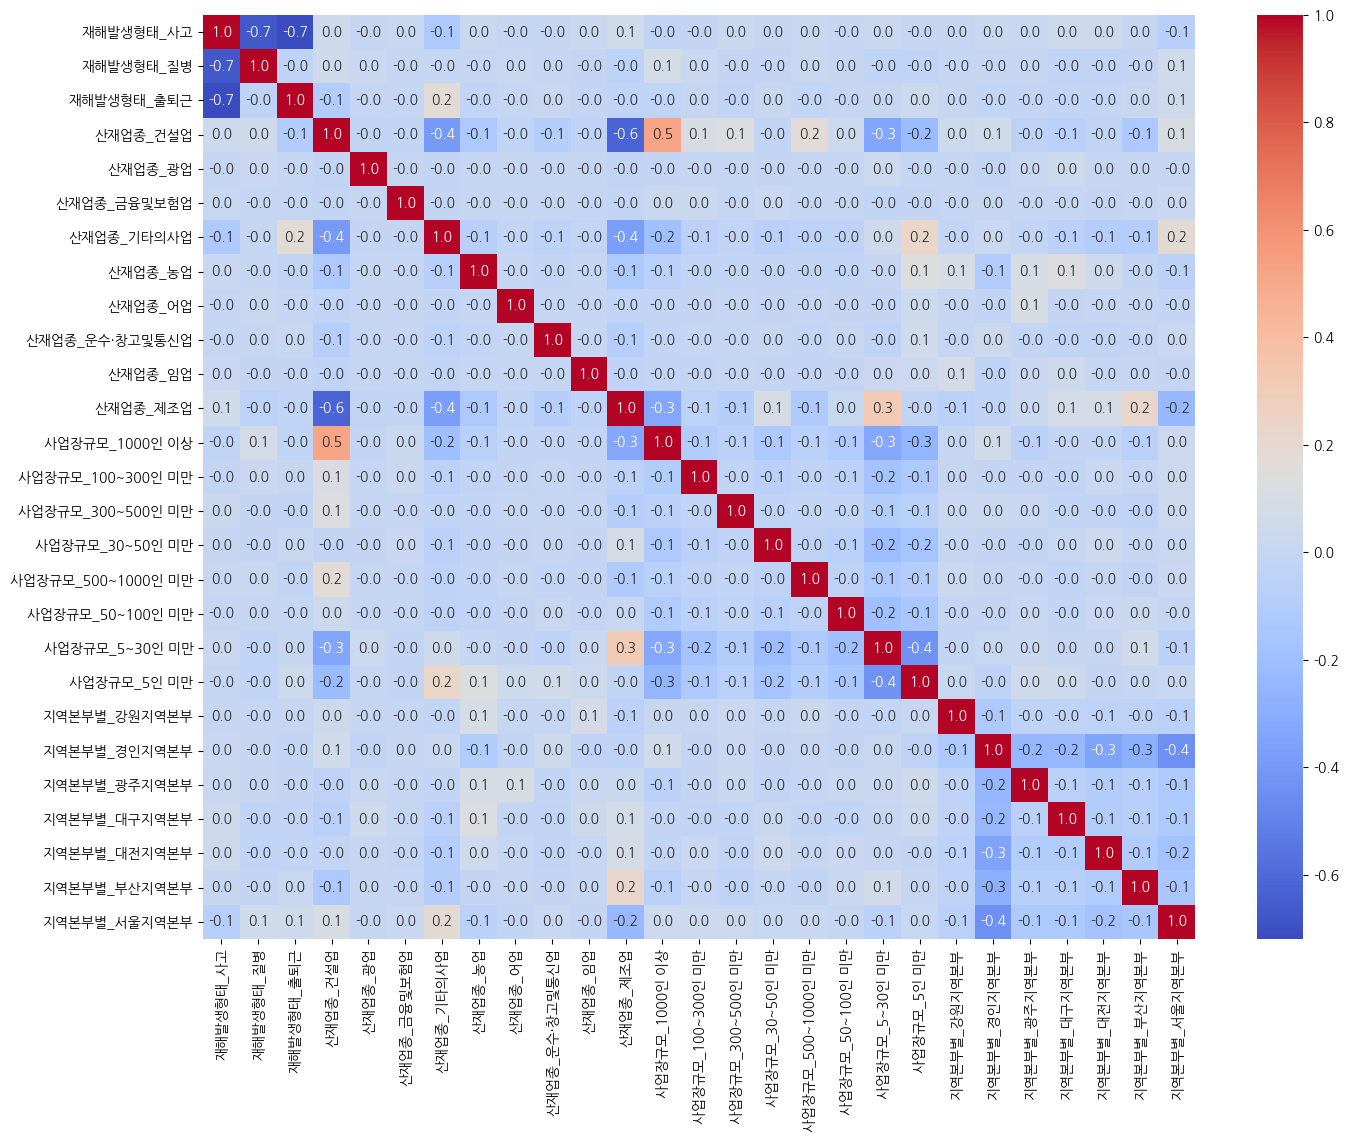

In [66]:
# 상관관계 히트맵

# figure size 설정
fig, ax = plt.subplots(figsize=(16, 12))

# 히트맵 그리기
sns.heatmap(df_final.corr(), ax=ax, annot=True, fmt='.1f', cmap='coolwarm')

plt.show()

### 상관관계 히트맵 인사이트
cf. 같은 범주 내 변수 고려 X

* 산재업종_건설업 & 사업장규모_1000인 이상 (0.5)
* 산재업종_제조업 & 사업장규모_5~30인 미만 (0.3)

### 3. 모델 구현

* 학습 목적: 특정 산업 업종, 산업체 지역, 사업장 규모에서 어떤 재해가 많이 발생하는지 예측할 수 있다.
* 데이터 구조
    * y = 재해발생형태
    * x = 산재업종, 사업장규모, 지역본부별

* 다중 클래스 분류 (Multi-class Classification)
1. Scikit-learb
2. Keras (TensorFlow)
3. Pytorch

In [69]:
# == 1. Scikit-learn 기반 모델 ==
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X = df_final.drop(columns=['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근'])
y = df['재해발생형태'] # scikit-learn은 정수 레이블 기대

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"y_train head:\n{pd.Series(y_train).head()}") # Converted to Series before calling head()

# == 모델 학습 ==

### A. 로지스틱 회귀 (Logistic Regression)
# - 선형 모델, 빠르고 해석 용이. 기준 모델로 좋음.
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42) # max_iter 증가
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

### B. 랜덤 포레스트 (Random Forest Classifier)
# - 앙상블 모델, 비선형 관계 학습 가능, 과적합에 강함.
print("\n--- Random Forest Classifier ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

### C. 그래디언트 부스팅 (Gradient Boosting Classifier)
# - 앙상블 모델, 랜덤 포레스트보다 예측 성능이 높은 경향이 있음 (과적합 주의). XGBoost, LightGBM, CatBoost 등 고급 버전도 존재.
print("\n--- Gradient Boosting Classifier ---")
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(classification_report(y_test, y_pred_gb))

### D. 서포트 벡터 머신 (Support Vector Machine - SVC)
# - 고차원 공간에서 분류를 잘 수행. 커널 트릭으로 비선형 문제 해결 가능.
print("\n--- Support Vector Classifier (SVC) ---")
# SVC는 데이터 스케일링에 민감하므로 실제 적용 시 스케일링 필요
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train, y_train) # 스케일링 없이 실행 (성능 저하 가능성 있음)
y_pred_svc = svc_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print(classification_report(y_test, y_pred_svc))

X_train shape: (7277, 24), y_train shape: (7277,)
y_train head:
0    0
1    0
2    0
3    0
4    2
dtype: int64

--- Logistic Regression ---
Accuracy: 0.9291
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1691
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        70

    accuracy                           0.93      1820
   macro avg       0.31      0.33      0.32      1820
weighted avg       0.86      0.93      0.89      1820


--- Random Forest Classifier ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9286
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1691
           1       0.00      0.00      0.00        59
           2       0.33      0.01      0.03        70

    accuracy                           0.93      1820
   macro avg       0.42      0.34      0.33      1820
weighted avg       0.88      0.93      0.90      1820


--- Gradient Boosting Classifier ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9291
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1691
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        70

    accuracy                           0.93      1820
   macro avg       0.31      0.33      0.32      1820
weighted avg       0.86      0.93      0.89      1820


--- Support Vector Classifier (SVC) ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9291
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1691
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        70

    accuracy                           0.93      1820
   macro avg       0.31      0.33      0.32      1820
weighted avg       0.86      0.93      0.89      1820



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


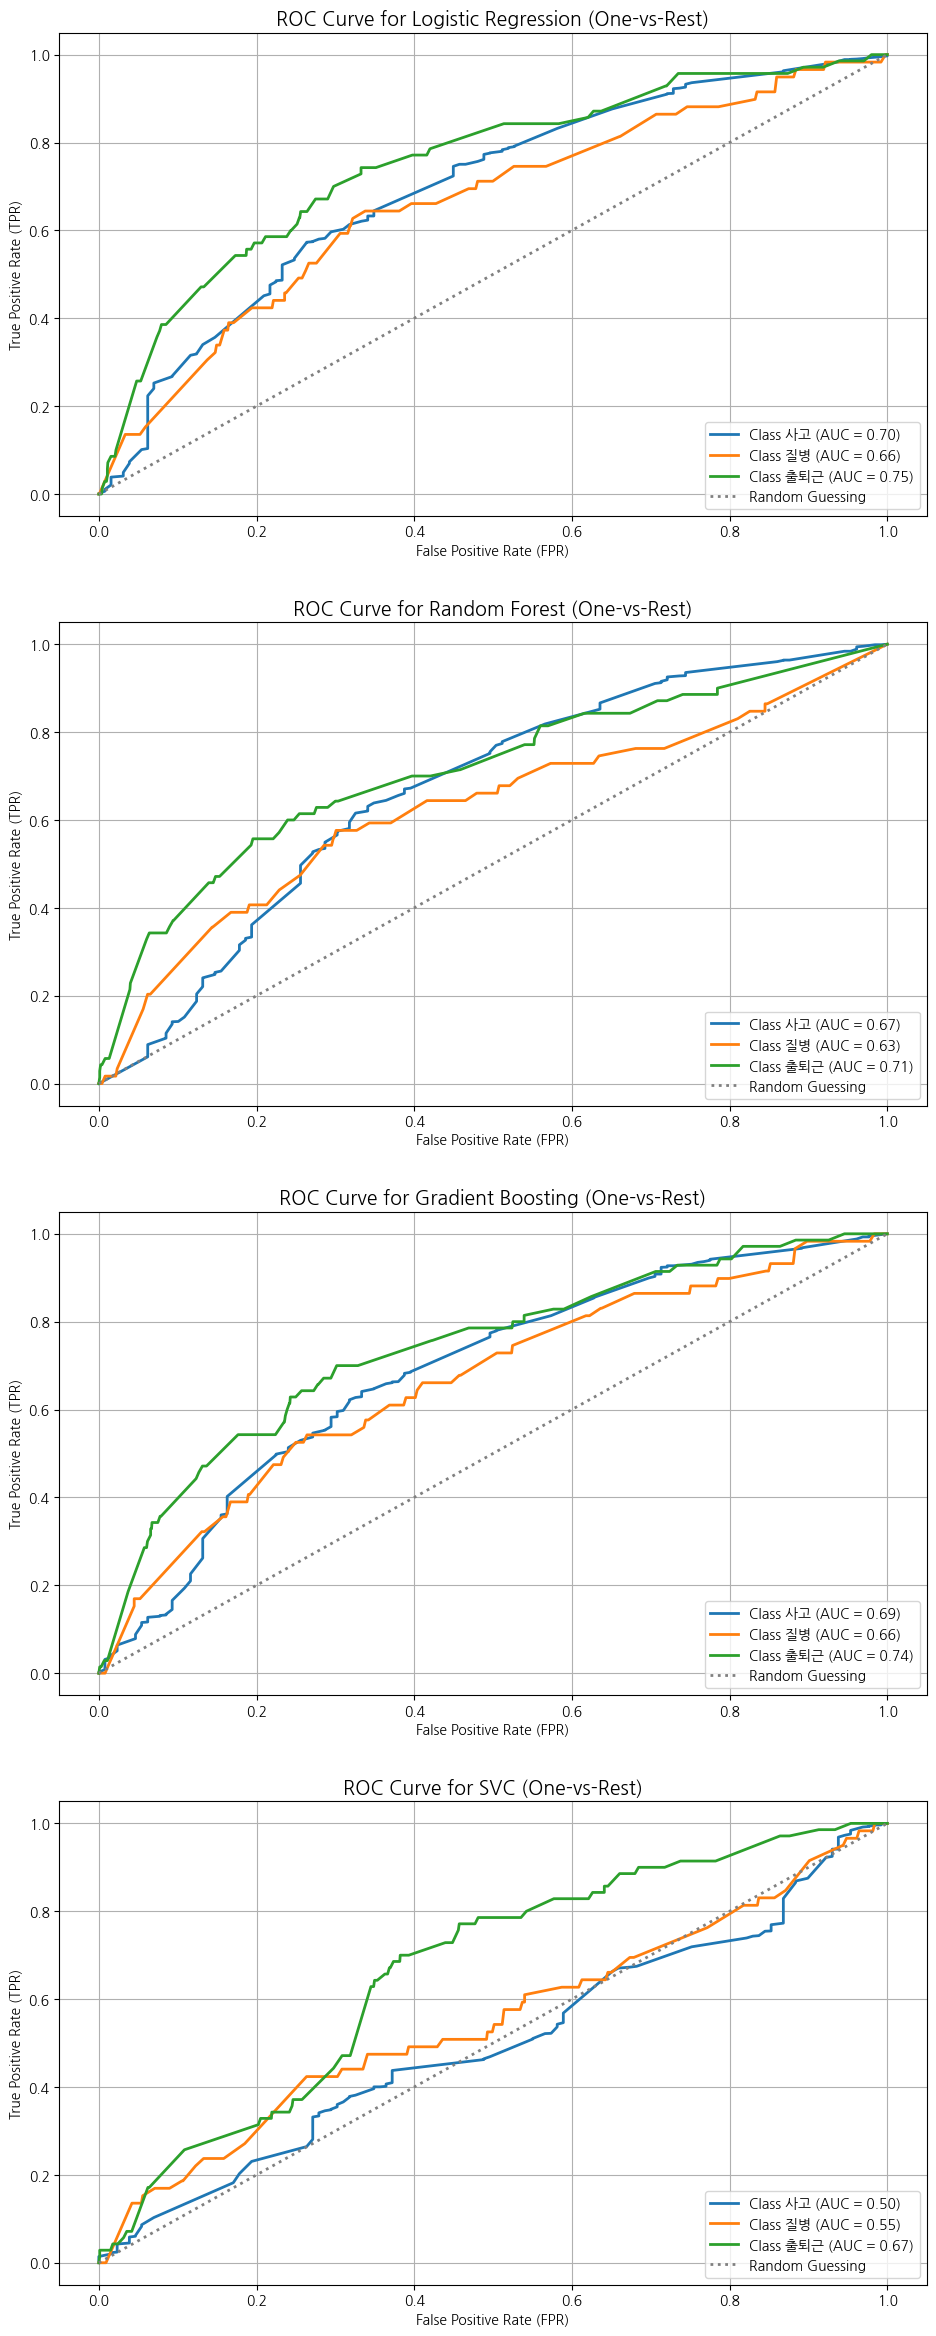

In [80]:
# == ROC 성능 지표 ==
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os

# ROC 곡선을 위해 y_test를 원-핫 인코딩 형태로 변환
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes = y_test_binarized.shape[1]
class_names = lb.classes_ # Get class names from the label encoder used previously

# Add font path logic again for robustness
candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",          # 가장 선호
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",   # 대체 1
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",   # 대체 2 (환경에 따라 위치가 다름)
]

font_path = None
for p in candidates:
    if os.path.exists(p):
        font_path = p
        break

if font_path is None:
    raise FileNotFoundError("한글 폰트를 찾지 못했습니다. 위 apt-get 설치 로그를 확인해 주세요.")

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

# 모델 정의 및 리스트에 저장
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC': SVC(random_state=42, probability=True) # Set probability=True for SVC
}


# == 시각화: ROC 곡선 (One-vs-Rest) ==
# 서브플롯 설정 (모델 수만큼)
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(10, 6 * len(models))) # Stack plots vertically
axes = axes.flatten() # 2D 배열을 1D로 변환하여 쉽게 접근

# 각 모델별 ROC 곡선 그리기
for i, (name, model) in enumerate(models.items()):

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측 확률 (predict_proba 사용)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        # This case should not happen with probability=True for SVC, but keep for robustness
        print(f"Warning: Model {name} does not have predict_proba. Skipping ROC.")
        continue

    # ROC 곡선 및 AUC 계산 for each class
    for class_id in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, class_id], y_pred_proba[:, class_id])
        roc_auc = auc(fpr, tpr)

        # Plotting for the current model and current class
        axes[i].plot(fpr, tpr, lw=2, label=f'Class {label_encoder.classes_[class_id]} (AUC = {roc_auc:.2f})')

    # Subplot title and labels
    axes[i].plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':', label='Random Guessing')
    axes[i].set_title(f'ROC Curve for {name} (One-vs-Rest)', fontsize=14)
    axes[i].set_xlabel('False Positive Rate (FPR)')
    axes[i].set_ylabel('True Positive Rate (TPR)')
    axes[i].legend(loc="lower right")
    axes[i].grid(True)

# Overall plot layout adjustment and display
plt.tight_layout(pad=3.0) # Adjust spacing between plots
plt.show()

### ROC 곡선 시각화 결과
* 로지스틱 회귀가 가장 높은 성능을 보임

### 모델 결정
* 로지스틱 회귀

In [82]:
pip install tensorflow

In [83]:
# == 2. Keras 기반 모델 ==

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report

# ----- 1. 데이터 준비  -----
X = df_final.drop(columns=['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근'])
y = df_final[['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근']]

X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}, y_train_onehot shape: {y_train_onehot.shape}")
print(f"y_train_onehot head:\n{y_train_onehot.head()}")


# ----- 2. Keras 모델  -----

### A. 다층 퍼셉트론 (Multi-Layer Perceptron, MLP)
# - 신경망 모델, 복잡한 비선형 관계 학습 가능.
print("\n--- Keras MLP Model ---")

# 모델 구성
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)), # 입력층: 피처 개수
    layers.Dense(64, activation='relu'),      # 은닉층 1
    layers.Dropout(0.3),                       # 과적합 방지 (드롭아웃)
    layers.Dense(32, activation='relu'),      # 은닉층 2
    layers.Dropout(0.3),
    layers.Dense(y_train_onehot.shape[1], activation='softmax') # 출력층: 클래스 개수, softmax 활성화
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # 다중 클래스 분류에 적합한 손실 함수
              metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train_onehot,
                    epochs=50,                # 에포크 수
                    batch_size=32,            # 배치 크기
                    validation_split=0.2,     # 검증 데이터 분리
                    verbose=0) # 학습 과정 출력을 줄임

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# 예측 (확률 출력)
y_pred_proba_keras = model.predict(X_test)
# 가장 높은 확률을 가진 클래스 인덱스 선택 (정수 레이블로 변환)
y_pred_labels_keras = np.argmax(y_pred_proba_keras, axis=1)
y_true_labels_keras = np.argmax(y_test_onehot.values, axis=1)

print("\nKeras Classification Report (using argmax for labels):")
print(classification_report(y_true_labels_keras, y_pred_labels_keras, target_names=['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근']))

X_train shape: (7277, 24), y_train_onehot shape: (7277, 3)
y_train_onehot head:
      재해발생형태_사고  재해발생형태_질병  재해발생형태_출퇴근
7618        1.0        0.0         0.0
7115        1.0        0.0         0.0
7518        1.0        0.0         0.0
8808        1.0        0.0         0.0
4262        0.0        0.0         1.0

--- Keras MLP Model ---
Test Accuracy: 0.9291
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Keras Classification Report (using argmax for labels):
              precision    recall  f1-score   support

   재해발생형태_사고       0.93      1.00      0.96      1691
   재해발생형태_질병       0.00      0.00      0.00        59
  재해발생형태_출퇴근       0.00      0.00      0.00        70

    accuracy                           0.93      1820
   macro avg       0.31      0.33      0.32      1820
weighted avg       0.86      0.93      0.89      1820



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
# == 3. Pytorch 기반 모델 ==

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# ----- 1.  데이터 준비 -----
X = df_final.drop(columns=['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근'])
y = df_final[['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근']]

X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# PyTorch Tensor 형태로 변환
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_onehot.values, dtype=torch.float32) # y도 float32
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_onehot.values, dtype=torch.float32)

# DataLoader 생성 (배치 학습을 위함)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ----- 2. PyTorch 모델 추천 및 코드 -----

### A. 다층 퍼셉트론 (Multi-Layer Perceptron, MLP)
print("\n--- PyTorch MLP Model ---")

# 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x # Softmax는 손실 함수 내부에서 적용하는 것이 일반적 (CrossEntropyLoss)

input_dim = X_train.shape[1]
output_dim = y_train_onehot.shape[1] # 3개의 클래스

model_pt = SimpleMLP(input_dim, output_dim)

# 손실 함수 및 옵티마이저
# nn.CrossEntropyLoss는 내부적으로 Softmax와 NLLLoss를 포함하며,
# y_true는 원-핫 인코딩이 아닌 정수 레이블을 기대하므로 y_train_tensor를 변환해야 함
# y_train_tensor_labels = torch.argmax(y_train_tensor, dim=1)
# y_test_tensor_labels = torch.argmax(y_test_tensor, dim=1)
# loss_fn = nn.CrossEntropyLoss()

# 또는 y_train_tensor 그대로 사용하고 싶다면 F.log_softmax + NLLLoss 또는 BCEWithLogitsLoss (이 경우 output_dim은 1)
# 일반적으로 다중 클래스 분류에서 y_onehot 형태를 사용한다면 Keras의 categorical_crossentropy와 유사하게
# torch.nn.functional.softmax (output) + torch.nn.functional.nll_loss (y_onehot_tensor_labels)
# 또는 출력층에 softmax를 직접 넣고 nn.BCELoss(y_onehot)
#
# 가장 일반적인 방법: 출력층에 softmax를 넣지 않고 CrossEntropyLoss 사용 (y는 정수 레이블)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

# PyTorch 학습을 위해 y_train_onehot을 정수 레이블로 변환
y_train_tensor_labels = torch.argmax(y_train_tensor, dim=1)
y_test_tensor_labels = torch.argmax(y_test_tensor, dim=1)

# 학습
epochs = 50
for epoch in range(epochs):
    model_pt.train()
    for batch_X, batch_y_onehot in train_loader:
        # CrossEntropyLoss는 정수 레이블을 기대하므로 y_onehot을 정수 레이블로 변환
        batch_y_labels = torch.argmax(batch_y_onehot, dim=1)

        optimizer.zero_grad()
        outputs = model_pt(batch_X)
        loss = loss_fn(outputs, batch_y_labels)
        loss.backward()
        optimizer.step()

# 평가
model_pt.eval()
with torch.no_grad():
    y_pred_proba_pt = model_pt(X_test_tensor)
    y_pred_labels_pt = torch.argmax(y_pred_proba_pt, dim=1) # 예측된 클래스 (정수 레이블)

    accuracy = accuracy_score(y_test_tensor_labels.numpy(), y_pred_labels_pt.numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

    print("\nPyTorch Classification Report:")
    print(classification_report(y_test_tensor_labels.numpy(), y_pred_labels_pt.numpy(), target_names=['재해발생형태_사고', '재해발생형태_질병', '재해발생형태_출퇴근']))


--- PyTorch MLP Model ---
Test Accuracy: 0.9291

PyTorch Classification Report:
              precision    recall  f1-score   support

   재해발생형태_사고       0.93      1.00      0.96      1691
   재해발생형태_질병       0.00      0.00      0.00        59
  재해발생형태_출퇴근       0.00      0.00      0.00        70

    accuracy                           0.93      1820
   macro avg       0.31      0.33      0.32      1820
weighted avg       0.86      0.93      0.89      1820



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 결론

모델 결정
* Scikit-learn: logistic 회귀 (accuracy: 0.93)
* Tensorflow (accuracy: 0.93)
* PyTorch (accuracy: 0.93)

모델 활용 가능성
*  어떤 '산재업종', '사업장규모', '지역본부별'의 산업현장에 어떤 유형의 산재 사고가 많이 발생하는지 예측할 수 있음.
* EDA 결과: 건설업, 제조업 산업/ 5~30인 미만, 5인 미만, 1000인 이상/ 경인, 서울 지역에 사고 재해 발생 건수가 많음.
* 모델 학습 결과: 모델 학습을 통해, 산재업종, 사업장규모, 지역본부 특성을 조합했을 때 특히 **어떤 공장**에서 사고 재해가 많이 발생했는지 특정할 수 있음. **즉, 재해 위험이 높은 공장을 특정할 수 있는 보다 구체적인 근거를 제공함**.
